# Паспорт A/B теста

**Гипотеза:** Если понизить коэффициент Surge в 2 раза (коэффициент, повышающий цену во время высокого спроса), то это увеличит на 3%( или больше) конверсию в заказ среди пользователей, которые увидели цену во время действия Surge.

**Нулевая гипотеза (H₀):** Понижение коэффициента Surge не влияет на конверсию в заказ.

**Альтернативная гипотеза (H₁):** Понижение коэффициента Surge увеличивает конверсию в заказ среди пользователей.



**Тестируемое изменение:** как повлияет снижение Surge на конверсию в поездку.

**Генеральная совокупность:** все пользователи, которые увидели цену во время действия surge.

**Первичная метрика:** CR из просмотра цены в заказ (order_made).

**Вторичные метрики:** Общий доход на пользователя; Конверсия в завершение поездки (ride_completed), время ожидания.


**Тип данных:** Бинарные (сделан заказ — да/нет), непрерывные (коэффициент Surge).

**Используемая статистика:** Тест Манна–Уитни.

**Тип теста (tails):** Двухсторонний.

**Текущая конверсия:** 72.28% (price_seen to order_made в период Surge).

**Минимальный обнаруживаемый эффект (MDE):** 3%

**Уровень значимости α:** 5%.

**Мощность (1−β):** 80%.

**Минимальный размер каждой группы:** 3527.

**Сплитование:** 50 / 50 (разбивка - случайным способом, проверка на однородность - тест Манна-Уитни по distance и age).

**Длительность теста:** 7 дней.

# Разделение на тестовую и контрольную группы

In [3]:
import pandas as pd

df = pd.read_csv(r'C:\Users\AAA\Desktop\user_sessions_taxi.csv')

df.head(5)

,Unnamed: 0,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
1,1,752172,5,Android,economy,no surge,1,1,1,1,0,1,2.908468,27,high
2,2,486559,15,Android,comfort,no surge,1,1,1,1,0,0,7.224614,21,high
3,3,304024,0,Android,economy,no surge,1,1,1,1,0,1,1.874349,52,low
4,4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low


In [4]:
# Фильтрация строк
df_filtered = df[df['surge'] == 'surge']

df_price_seen = df_filtered[df_filtered['price_seen'] == 1]

In [6]:
# Удаление строк, где значение в столбце 'distance' является null
df_price_seen = df_price_seen.dropna(subset=['distance'])
df_price_seen = df_price_seen.dropna(subset=['age'])

# Группируем данные по user_id с медиальными значениями по distance, age и hour
df_price_seen_median = df_price_seen.groupby('user_id').agg({
    'hour': 'median',
    'os': 'first',
    'order_class': 'first',
    'distance': 'median',
    'age': 'median',
    
}).reset_index()

df_price_seen_median.head(4)

,user_id,hour,os,order_class,distance,age
0,100093,4.0,iOS,economy,9.090279,21.0
1,100118,8.0,iOS,comfort,10.942383,26.0
2,100134,20.0,iOS,business,13.714453,25.0
3,100166,8.0,Android,economy,4.448118,18.0


In [7]:
# Распределение по группам случайным образом с фиксацией случайности.

group_a = df_price_seen_median.sample(frac=0.5, random_state=42)  # Группа A (50% случайно выбранных строк)
group_b = df_price_seen_median.drop(group_a.index)  # Группа B (оставшиеся строки)


Данные разделены. Теперь проверим однородность получившихся групп по столбцам distance и age. 

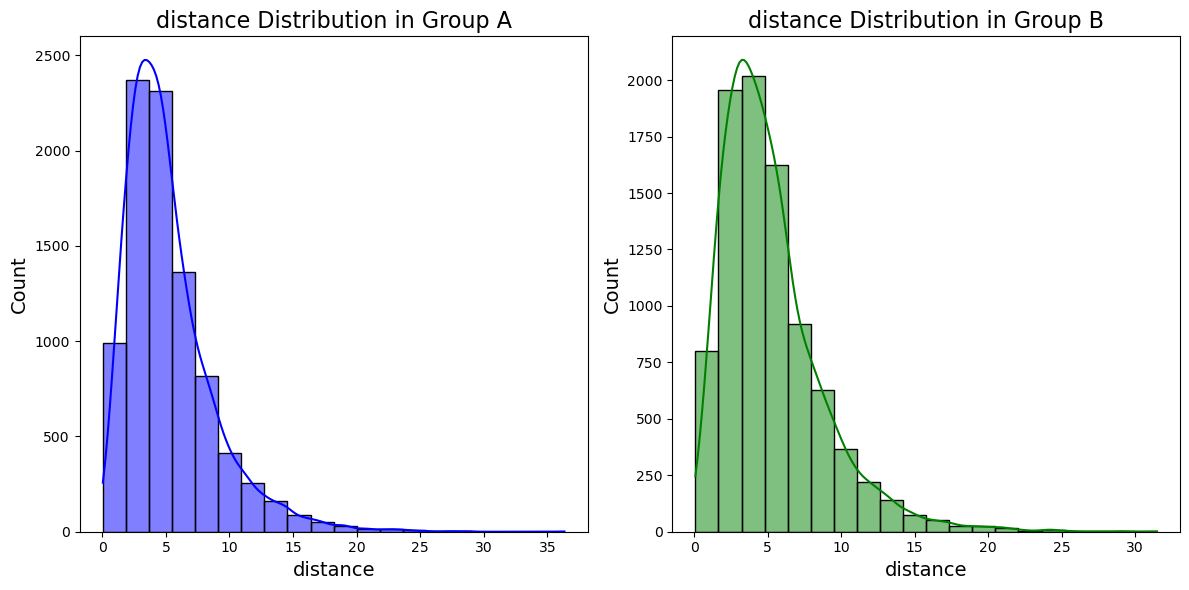

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# График распределения для группы A
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Два графика в одной строке
sns.histplot(group_a['distance'], kde=True, color='blue', bins=20)
plt.title('distance Distribution in Group A', fontsize=16)
plt.xlabel('distance', fontsize=14)
plt.ylabel('Count', fontsize=14)

# График распределения для группы B
plt.subplot(1, 2, 2)
sns.histplot(group_b['distance'], kde=True, color='green', bins=20)
plt.title('distance Distribution in Group B', fontsize=16)
plt.xlabel('distance', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.tight_layout()
plt.show()

In [9]:
# Т.к. распределения логонормальные, t-тест не подходит, поэтому используем тест Манна-Уитни для сравнения выборок.

from scipy.stats import mannwhitneyu

stat, p_val = mannwhitneyu(group_a['distance'], group_b['distance'])

print(f"Mann-Whitney U test: p-value = {p_val}")

Mann-Whitney U test: p-value = 0.38197926446686836


Значение p-value (0.38)  > α = 0,05. Выборки не имеют статистически значимых различий.

In [10]:
# Также используем тест Манна-Уитни для сравнения групп.

stat, p_val = mannwhitneyu(group_a['age'], group_b['age'])
print(f"Mann-Whitney U test: p-value = {p_val}")

Mann-Whitney U test: p-value = 0.7891808881933662


По столбцу age группы также равномерные.

### После того, как сформировали две группы, мы можем запускать тест.

# Анализ результатов

In [16]:
df = pd.read_csv(r'C:\Users\AAA\Desktop\post_abtest_data.csv')

# Преобразование столбца 'date' в формат даты
df['date'] = pd.to_datetime(df['date'])

# Фильтруем данные.
df_surge = df[df['surge'] == 'surge']

df_surge.head(5)

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
5,486559,2020-05-25,1,Control,1,0,surge,Android,NaN,NaN,Control
8,486559,2020-05-28,1,Control,1,0,surge,iOS,NaN,NaN,Control


In [17]:
# Фильтруем группы Control и Test
df_control = df_surge[df_surge['group'] == 'Control']
df_test = df_surge[df_surge['group'] == 'Test']


In [18]:
# Убедимся, что user_id уникальны в каждой группе
control_user_ids = set(df_control['user_id'].unique())
test_user_ids = set(df_test['user_id'].unique())

# Найдем пересечения
duplicate_user_ids = control_user_ids.intersection(test_user_ids)

# Выводим результаты
print(f"Количество уникальных user_id в контрольной группе: {len(control_user_ids)}")
print(f"Количество уникальных user_id в тестовой группе: {len(test_user_ids)}")
print(f"Количество user_id, которые присутствуют и в контрольной, и в тестовой группе: {len(duplicate_user_ids)}")

Количество уникальных user_id в контрольной группе: 8505
Количество уникальных user_id в тестовой группе: 8445
Количество user_id, которые присутствуют и в контрольной, и в тестовой группе: 0


In [19]:
# Подсчет количества записей в группах по дням

control_counts = df_control.groupby('date').size().reset_index(name='control_count')
test_counts = df_test.groupby('date').size().reset_index(name='test_count')

# Вывод результатов
print("Control Group Counts by Date:")
print(control_counts)

print("\nTest Group Counts by Date:")
print(test_counts)

Control Group Counts by Date:
        date  control_count
0 2020-05-25           2013
1 2020-05-26           2017
2 2020-05-27           2065
3 2020-05-28           2061
4 2020-05-29           2043
5 2020-05-30           2101
6 2020-05-31           2083

Test Group Counts by Date:
        date  test_count
0 2020-05-25        2066
1 2020-05-26        2011
2 2020-05-27        2082
3 2020-05-28        1975
4 2020-05-29        2065
5 2020-05-30        2069
6 2020-05-31        2101


Как видно в таблице, на каждый день в каждой группе достаточное и приблизительно равное кол-во наблюдений.

In [20]:
# Считаем конверсии price_seen to order_made для каждой группы.

control_price_seen_count = df_control['price_seen'].sum()
control_order_made_count = df_control['order_made'].sum()

test_price_seen_count = df_test['price_seen'].sum()
test_order_made_count = df_test['order_made'].sum()

conversion_control = control_order_made_count / control_price_seen_count if control_price_seen_count > 0 else 0
conversion_test = test_order_made_count / test_price_seen_count if test_price_seen_count > 0 else 0

print(f"Конверсия группы control: {conversion_control:.2%}")
print(f"Конверсия группы test: {conversion_test:.2%}")
print(f"Разница: {(conversion_test - conversion_control) :.2%}")

Конверсия группы control: 60.01%
Конверсия группы test: 61.81%
Разница: 1.81%


В результате конверсия увеличилась на 1.81%, вместо 3% - цель не достигнута. 
Проверим стат. значимость результатов и посмотрим на **p-value**.

In [23]:
# Подсчёт общего количества заказов и показов цены в каждой группе
control_orders = df_control['order_made'].sum()
control_total = df_control['price_seen'].sum()

test_orders = df_test['order_made'].sum()
test_total = df_test['price_seen'].sum()

# Проверка через z-тест для пропорций
count = np.array([control_orders, test_orders])  # число успешных заказов
nobs = np.array([control_total, test_total])     # общее число показов цены

z_stat, p_val = proportions_ztest(count, nobs)

print(f"Z-статистика: {z_stat:.3f}")
print(f"p-value: {p_val:.4f}")

# Интерпретация результата
if p_val < 0.05:
    print("Различие между группами статистически значимо (отвергаем H₀)")
else:
    print("Нет статистически значимого различия (не отвергаем H₀)")

Z-статистика: -3.137
p-value: 0.0017
Различие между группами статистически значимо (отвергаем H₀)


Также посмотрим на **p-value в динамике**, чтобы исключить влияние аномалий и непредвиденных событий.

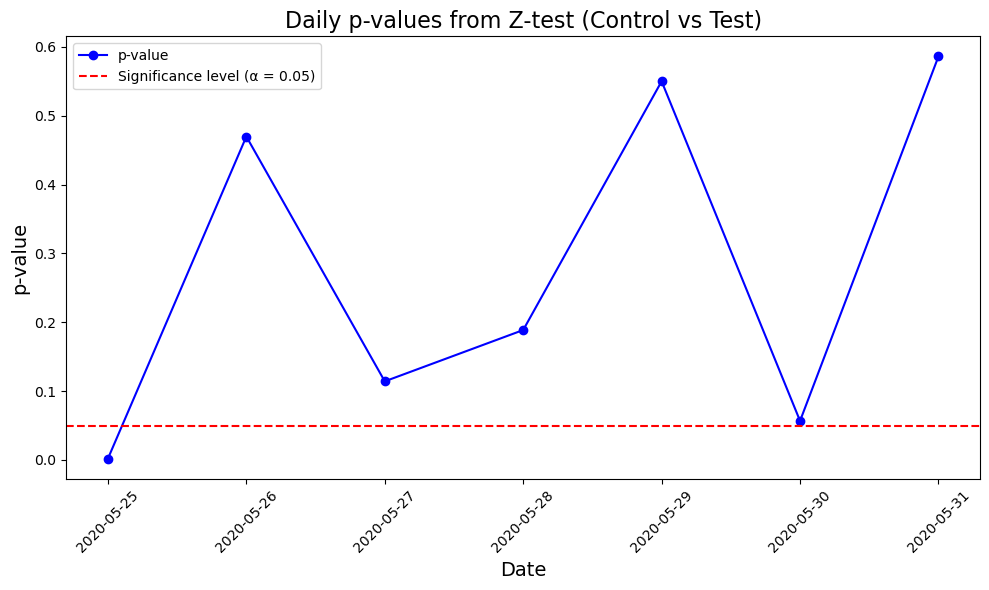

In [21]:
# Построим периодический p-value, чтобы проанализировать в динамике. 
# Посколько данные бинарны, используем z-тест.

import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt

p_values = []
dates = []

# Проходим по уникальным датам
for date in df_surge['date'].unique():
    # Фильтрация данных по конкретной дате
    daily_control = df_control[df_control['date'] == date]
    daily_test = df_test[df_test['date'] == date]

    # Проверка, что есть данные в обеих группах
    if len(daily_control) > 1 and len(daily_test) > 1:
        # Количество заказов (order_made == 1) в каждой группе
        control_orders = daily_control['order_made'].sum()
        test_orders = daily_test['order_made'].sum()

        # Общее количество наблюдений в каждой группе
        control_total = len(daily_control)
        test_total = len(daily_test)

        # Выполнение Z-теста для пропорций
        count = np.array([control_orders, test_orders])  # Количество успехов (заказов) в каждой группе
        nobs = np.array([control_total, test_total])     # Количество наблюдений в каждой группе

        z_stat, p_val = proportions_ztest(count, nobs)

        # Сохранение p-value и даты
        p_values.append(p_val)
        dates.append(date)

# Преобразуем даты и p-values в датафрейм для удобства
p_values_df = pd.DataFrame({'date': dates, 'p_value': p_values})

# Сортировка по дате
p_values_df = p_values_df.sort_values(by='date')

# Визуализация p-value по дням
plt.figure(figsize=(10, 6))
plt.plot(p_values_df['date'], p_values_df['p_value'], marker='o', linestyle='-', color='b', label='p-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level (α = 0.05)')  # Линия уровня значимости

# Добавляем подписи
plt.title('Daily p-values from Z-test (Control vs Test)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('p-value', fontsize=14)
plt.xticks(rotation=45)
plt.legend()

# Показ графика
plt.tight_layout()
plt.show()

### Результаты стабильны, сильных аномалий не наблюдается. На каждый день daily p_value > α из-за недостаточности данных в каждом дне (2000 вместо 3500).
### Поскольку выше рассчитан общий p_value и daily p_value < α в каждый из дней, нет необходимости делать поправку на множественное тестирование.

# Вывод

### Проведённый A/B-тест показал, что снижение коэффициента Surge оказывает статистически значимое влияние на конверсию: в тестовой группе прирост составил 1.81% (p-value < 0.05).

### Однако этот эффект оказался **слишком малым, чтобы оправдать потери в выручке**, связанные с понижением цен. Снижение Surge не привело к заметному росту заказов или другим выраженным бизнес-результатам.

### Компания может на основе этих результатов отказаться от внедрения подобного изменения и дальнейшие эксперименты стоит направить на другие аспекты ценообразования или улучшение пользовательского опыта.